In [59]:
cd '/home/jovyan/lib'

/home/jovyan/lib


In [87]:
import re
import requests
import db_helper as db
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import Normalizer
from sklearn.pipeline import make_pipeline
import seaborn as sns
%matplotlib inline

In [88]:
connection, cursor = db.connect_to_db()

In [89]:
get_some_docs = """
with tb1 as( SELECT A.PAGE_TEXT, C.CATEGORY_NAME FROM PAGE_DATA A, CATEGORY_DATA B, CATEGORY_INFO C
WHERE A.PAGEID = B.PAGEID AND B.MAINCATEGORYID = C.CATEGORYID AND C.CATEGORY_NAME = 'machine_learning' limit 150),
tb2 as 
(SELECT A.PAGE_TEXT, C.CATEGORY_NAME FROM PAGE_DATA A, CATEGORY_DATA B, CATEGORY_INFO C
WHERE A.PAGEID = B.PAGEID AND B.MAINCATEGORYID = C.CATEGORYID AND C.CATEGORY_NAME = 'business_software' limit 150)
select * from tb1 union all select * from tb2;
"""

In [90]:
df = db.query_to_dataframe(get_some_docs)

In [91]:
df.head()

,category_name,page_text
0,machine_learning,Data exploration is an approach similar to ini...
1,machine_learning,These datasets are used for machine learning r...
2,machine_learning,Machine learning is the subfield of computer s...
3,machine_learning,The following outline is provided as an overvi...
4,machine_learning,In Machine Learning if a statistical model is ...


In [16]:
#le = LabelEncoder()
#df['category_numerical'] = le.fit_transform(df['category_name'])

In [92]:
df.head()

,category_name,page_text
0,machine_learning,Data exploration is an approach similar to ini...
1,machine_learning,These datasets are used for machine learning r...
2,machine_learning,Machine learning is the subfield of computer s...
3,machine_learning,The following outline is provided as an overvi...
4,machine_learning,In Machine Learning if a statistical model is ...


In [93]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [94]:
tfidf_vectorizer = TfidfVectorizer(min_df = 1, stop_words = 'english')
TfidfVectorizer()

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,
        stop_words=None, strip_accents=None, sublinear_tf=False,
        token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
        vocabulary=None)

In [95]:
document_term_matrix_sps = tfidf_vectorizer.fit_transform(df.page_text)

In [96]:
document_term_matrix_sps

<300x14069 sparse matrix of type '<class 'numpy.float64'>'
	with 74656 stored elements in Compressed Sparse Row format>

In [97]:
document_term_matrix_df = pd.DataFrame(document_term_matrix_sps.toarray(),
                                       index=df.index,
                                       columns=tfidf_vectorizer.get_feature_names())

In [100]:
pd.concat([df['page_text'], document_term_matrix_df], axis=1).tail(2)

,page_text,aaai,aachen,aai,aaip,aall,aap,aashish,ab,abacus,...,zones,zoologist,zoology,zooming,zoubin,zucker,zuji,zukunftssicherheit,zurada,zurich
298,Intraboom is a software as a service Saas comp...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
299,InvoiceBerry is an online invoicing applicatio...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Perform SVD

In [101]:
n_components = 100
algorithm = 'randomized'
SVD = TruncatedSVD(n_components, algorithm)
normalizer = Normalizer(copy=False)
pipeline = make_pipeline(svd, normalizer)
lsa = pipeline.fit_transform(document_term_matrix_df)


In [102]:
lsa.shape

(300, 200)

In [86]:
latent_semantic_analysis = pd.DataFrame(lsa,
                                        index=document_term_matrix_df.index,
                                        columns=component_names)
latent_semantic_analysis['page'] = df['page_text']
latent_semantic_analysis['category'] = df['category_name']

ValueError: Shape of passed values is (200, 300), indices imply (100, 300)

In [54]:
latent_semantic_analysis.sample(4)

,component_1,component_2,component_3,component_4,component_5,component_6,component_7,component_8,component_9,component_10,...,component_93,component_94,component_95,component_96,component_97,component_98,component_99,component_100,page,category
95,0.237511,-0.038774,0.168717,-0.049937,-0.000695,0.022468,-0.030834,0.048477,-0.026071,-0.049037,...,0.031736,-0.030432,-0.029092,-0.076387,0.009631,-0.017454,-0.033584,0.045974,Knowledge integration is the process of synthe...,machine_learning
46,0.283566,-0.042368,-0.163293,-0.261206,-0.268342,-0.193240,0.134658,-0.184331,0.099110,0.023285,...,-0.023061,-0.006021,-0.012756,0.016371,0.035863,-0.012683,0.053672,0.034779,Data pre processing is an important step in th...,machine_learning
194,0.206872,0.198477,0.008783,-0.074554,0.003709,0.087878,-0.018832,0.015351,-0.028930,-0.075933,...,0.123541,0.000321,-0.097538,0.004230,0.039820,0.011346,-0.060886,0.071551,Collaborative software or groupware is applica...,business_software
214,0.160746,0.112323,-0.012651,-0.034629,-0.012634,0.045944,-0.044108,0.012822,-0.000716,-0.137706,...,0.069633,0.076173,-0.036495,0.015959,0.063234,0.048357,-0.112124,0.081372,Decision making software DM software is the na...,business_software


In [55]:
vocabulary_expression = pd.DataFrame(SVD.components_,
                                     index=component_names,
                                     columns=tfidf_vectorizer.get_feature_names()).T

In [56]:
vocabulary_expression['abs_component_1'] = np.abs(vocabulary_expression.component_1)
vocabulary_expression['abs_component_2'] = np.abs(vocabulary_expression.component_2)

In [57]:
vocabulary_expression.sort_values('abs_component_1',ascending=False).head(10)

,component_1,component_2,component_3,component_4,component_5,component_6,component_7,component_8,component_9,component_10,...,component_93,component_94,component_95,component_96,component_97,component_98,component_99,component_100,abs_component_1,abs_component_2
learning,0.372144,-0.293535,0.492249,0.041184,-0.011070,-0.098586,-0.005395,-0.078738,-0.019984,0.156556,...,0.014462,-0.014468,0.019590,-0.009670,-0.008675,-0.003880,-0.018829,-0.001587,0.372144,0.293535
data,0.252317,-0.001819,-0.223155,-0.342314,-0.292229,-0.236556,0.229128,-0.284544,0.039916,0.002886,...,-0.009049,-0.025951,-0.000477,0.021828,0.013744,-0.000318,-0.008596,-0.007069,0.252317,0.001819
business,0.143714,0.338284,-0.027515,-0.308985,0.431745,-0.209120,-0.035919,0.135471,0.032971,0.192665,...,-0.011763,0.027337,0.001751,0.014796,0.000476,0.005452,0.000131,0.008350,0.143714,0.338284
management,0.141596,0.390385,0.041162,0.377678,-0.065365,-0.024211,-0.253930,-0.181586,0.012264,0.137366,...,0.006010,0.012084,0.011839,-0.023598,0.043164,0.006931,-0.026904,0.000095,0.141596,0.390385
machine,0.135742,-0.083943,0.126769,-0.010177,-0.090517,-0.036762,-0.027201,0.020743,-0.051911,0.072273,...,0.000381,0.002135,0.012454,0.010248,-0.006529,-0.055254,0.002676,-0.000394,0.135742,0.083943
algorithm,0.130137,-0.099307,-0.012343,0.053080,0.063713,-0.012834,0.024631,-0.066307,0.164988,-0.017244,...,0.023032,-0.003604,-0.005184,-0.029919,0.032478,-0.001263,0.018184,0.009173,0.130137,0.099307
model,0.123209,-0.058595,-0.030824,0.026913,0.099995,0.022485,0.043461,-0.007805,-0.049098,-0.093247,...,0.003489,-0.005927,-0.015132,-0.014800,-0.002068,0.006342,-0.002622,-0.043117,0.123209,0.058595
software,0.118530,0.249980,0.016509,0.012493,-0.116812,0.043237,0.002311,-0.103042,-0.051907,-0.137872,...,0.038997,-0.042151,-0.055335,-0.013002,0.011678,-0.012195,-0.042243,0.032465,0.118530,0.249980
training,0.118045,-0.090810,-0.001897,0.050088,0.043623,-0.040223,0.052892,-0.121537,0.090417,0.047278,...,-0.035867,-0.009734,-0.022233,0.014022,0.017801,-0.027052,0.021387,-0.003927,0.118045,0.090810
algorithms,0.104042,-0.074127,0.004742,0.004449,-0.040194,-0.043366,-0.037290,0.004812,0.124140,0.023998,...,0.014506,0.008738,0.035534,0.026897,0.003893,0.017315,0.000334,-0.033664,0.104042,0.074127


In [58]:
vocabulary_expression.sort_values('abs_component_2',ascending=False).head(10)

,component_1,component_2,component_3,component_4,component_5,component_6,component_7,component_8,component_9,component_10,...,component_93,component_94,component_95,component_96,component_97,component_98,component_99,component_100,abs_component_1,abs_component_2
management,0.141596,0.390385,0.041162,0.377678,-0.065365,-0.024211,-0.253930,-0.181586,0.012264,0.137366,...,0.006010,0.012084,0.011839,-0.023598,0.043164,0.006931,-0.026904,0.000095,0.141596,0.390385
business,0.143714,0.338284,-0.027515,-0.308985,0.431745,-0.209120,-0.035919,0.135471,0.032971,0.192665,...,-0.011763,0.027337,0.001751,0.014796,0.000476,0.005452,0.000131,0.008350,0.143714,0.338284
learning,0.372144,-0.293535,0.492249,0.041184,-0.011070,-0.098586,-0.005395,-0.078738,-0.019984,0.156556,...,0.014462,-0.014468,0.019590,-0.009670,-0.008675,-0.003880,-0.018829,-0.001587,0.372144,0.293535
software,0.118530,0.249980,0.016509,0.012493,-0.116812,0.043237,0.002311,-0.103042,-0.051907,-0.137872,...,0.038997,-0.042151,-0.055335,-0.013002,0.011678,-0.012195,-0.042243,0.032465,0.118530,0.249980
enterprise,0.057796,0.150607,0.000871,0.014975,0.059005,-0.036322,-0.100295,-0.046351,0.010438,0.051691,...,-0.008294,-0.003142,0.025588,-0.040131,-0.060658,-0.053303,0.008167,0.033811,0.057796,0.150607
hp,0.041590,0.147270,0.041543,0.395352,-0.064362,-0.342327,0.476380,0.355792,0.040496,-0.005602,...,0.005813,-0.007312,-0.014952,-0.000793,0.009307,-0.037170,0.000818,0.017926,0.041590,0.147270
service,0.049046,0.137008,0.026199,0.136788,-0.036888,-0.069563,0.150164,0.079363,-0.006114,-0.003585,...,-0.021461,-0.019294,0.009708,0.012805,-0.015981,0.050585,0.056974,-0.040547,0.049046,0.137008
algorithm,0.130137,-0.099307,-0.012343,0.053080,0.063713,-0.012834,0.024631,-0.066307,0.164988,-0.017244,...,0.023032,-0.003604,-0.005184,-0.029919,0.032478,-0.001263,0.018184,0.009173,0.130137,0.099307
systems,0.084140,0.093792,0.051367,-0.053043,0.016046,0.024055,-0.010323,-0.001592,0.009117,0.060456,...,-0.038175,0.006990,0.004550,0.020914,-0.018550,0.028171,0.043917,-0.022989,0.084140,0.093792
training,0.118045,-0.090810,-0.001897,0.050088,0.043623,-0.040223,0.052892,-0.121537,0.090417,0.047278,...,-0.035867,-0.009734,-0.022233,0.014022,0.017801,-0.027052,0.021387,-0.003927,0.118045,0.090810


(-0.5, 0.8)

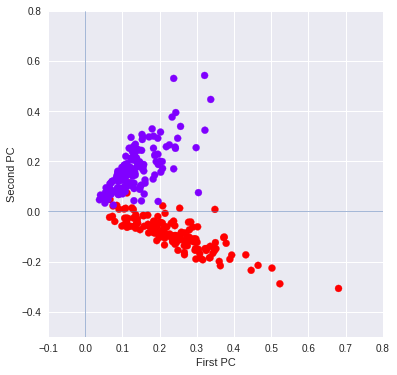

In [35]:
plt.figure(figsize=(6,6))
pc_1 = latent_semantic_analysis['component_1'].values
pc_2 = latent_semantic_analysis['component_2'].values

plt.scatter(pc_1, pc_2, c=df['category_numerical'], cmap='rainbow')

plt.xlabel('First PC')
plt.ylabel('Second PC')
plt.axvline(linewidth=0.5)
plt.axhline(linewidth=0.5)
plt.xlim(-.1,.8)
plt.ylim(-.5,.8)

(-0.5, 0.8)

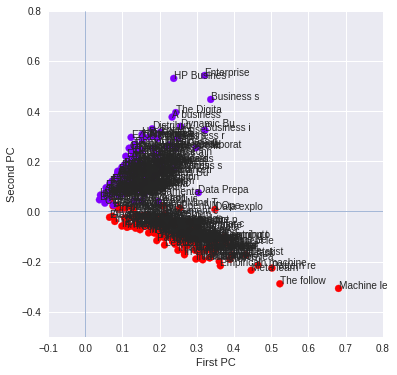

In [36]:
plt.figure(figsize=(6,6))
pc_1 = latent_semantic_analysis['component_1'].values
pc_2 = latent_semantic_analysis['component_2'].values

strings = df['page_text'].values
for i, (x, y) in enumerate(zip(pc_1, pc_2)): 
    plt.text(x,y,strings[i][:10])

plt.scatter(pc_1, pc_2, c=df['category_numerical'], cmap='rainbow')

plt.xlabel('First PC')
plt.ylabel('Second PC')
plt.axvline(linewidth=0.5)
plt.axhline(linewidth=0.5)
plt.xlim(-.1,.8)
plt.ylim(-.5,.8)

In [37]:
mlearning_make = latent_semantic_analysis['category'] == 'machine_learning'

In [41]:
bizsoft_make = latent_semantic_analysis['category'] == 'business_software'

In [42]:
latent_semantic_analysis[bizsoft_make]['page'].values[0]

'Business software or a business application is any software or set of computer programs used by business users to perform various business functions These business applications are used to increase productivity to measure productivity and to perform other business functions accurately By and large business software is likely to be developed to meet the needs of a specific business and therefore is not easily transferable to a different business environment unless its nature and operation is identical Due to the unique requirements of each business off the shelf software is unlikely to completely address a company s needs However where an on the shelf solution is necessary due to time or monetary considerations some level of customization is likely to be required Exceptions do exist depending on the business in question and thorough research is always required before committing to bespoke or off the shelf solutions Some business applications are interactive i e  they have a graphical u

In [38]:
latent_semantic_analysis[mlearning_make]['page'].values[0]

'Data exploration is an approach similar to initial data analysis whereby a data analyst uses visual exploration to understand what is in a dataset and the characteristics of the data rather than through traditional data management systems These characteristics can include size or amount of data completeness of the data correctness of the data possible relationships amongst data elements or files tables in the data Data exploration is typically conducted using a combination of automated and manual activities Automated activities can include data profiling or data visualization or tabular reports to give the analyst an initial view into the data and an understanding of key characteristics This is often followed by manual drill down or filtering of the data to identify anomalies or patterns identified through the automated actions Data exploration can also require manual scripting and queries into the data e g using languages such as SQL or R or using Excel or similar tools to view the r

In [43]:
latent_semantic_analysis[bizsoft_make]

,component_1,component_2,component_3,component_4,component_5,component_6,component_7,component_8,component_9,component_10,...,component_293,component_294,component_295,component_296,component_297,component_298,component_299,component_300,page,category
150,0.337254,0.446047,-0.039182,-0.223410,0.240757,-0.139149,-0.023065,0.025589,0.002756,0.066598,...,-0.181591,-0.075281,0.113000,0.030557,0.003123,0.015455,-0.061971,-0.001076,Business software or a business application is...,business_software
151,0.083211,0.133059,0.011959,0.040192,-0.077865,0.088686,-0.028739,-0.030050,-0.003333,-0.052247,...,0.000016,-0.002466,-0.007218,-0.000359,0.001893,-0.003685,-0.003362,-0.000067,AccuSystems LLC is an American company headqua...,business_software
152,0.125728,0.145749,0.010628,0.005971,-0.000850,0.051161,-0.038787,0.007258,-0.003638,-0.046156,...,0.009833,0.003679,-0.006795,-0.005675,0.000744,0.001454,-0.000100,-0.000014,Active policy management is business oriented ...,business_software
153,0.079042,0.081754,0.026030,0.015182,-0.063488,0.078576,0.031528,0.010153,-0.013857,-0.052103,...,-0.002784,-0.001898,0.000893,0.019820,0.005489,-0.000617,0.003833,0.000174,Alexandria is browser based cross platform lib...,business_software
154,0.093285,0.087589,-0.025087,-0.106275,-0.111985,0.027709,0.102081,-0.067545,-0.018089,-0.094821,...,-0.004419,-0.001584,0.002329,0.003294,0.002067,0.002656,0.011346,-0.000010,Alteryx is an American computer software compa...,business_software
155,0.066023,0.071319,0.018370,-0.058325,-0.008640,0.351652,0.160943,0.083927,0.123308,0.243088,...,-0.006863,-0.000585,-0.002231,-0.003109,0.001721,-0.004026,-0.004154,-0.000258,Amadeus is a computer reservations system or g...,business_software
156,0.091898,0.151107,0.015214,0.115964,-0.029452,-0.016392,-0.042138,-0.030007,-0.016303,0.017235,...,0.000255,0.002142,-0.015717,0.013232,0.001165,-0.004395,0.016999,0.001911,AMS Device Manager is plant asset management s...,business_software
157,0.114655,0.151624,0.011146,-0.057812,-0.128278,0.036893,0.114367,-0.032060,-0.023129,-0.142589,...,-0.002333,-0.001442,0.001349,0.002580,-0.002525,-0.001795,0.001425,0.000359,Angelfish Software is an on premises self host...,business_software
158,0.196232,0.186791,-0.011199,-0.038299,-0.128425,0.020705,0.049075,-0.098804,-0.031328,-0.076977,...,-0.007327,-0.007602,0.010657,-0.009525,-0.000425,-0.000278,0.007765,0.000631,An applicant tracking system ATS is a software...,business_software
159,0.153538,0.169823,-0.056455,-0.151733,0.006840,-0.121264,0.081455,-0.037592,0.013723,-0.000317,...,0.015880,0.020828,-0.013703,-0.012315,0.000719,0.003586,0.007128,0.001187,Application retirement also called application...,business_software


In [44]:
latent_semantic_analysis[mlearning_make]

,component_1,component_2,component_3,component_4,component_5,component_6,component_7,component_8,component_9,component_10,...,component_293,component_294,component_295,component_296,component_297,component_298,component_299,component_300,page,category
0,0.348537,0.007776,-0.120788,-0.299280,-0.276056,-0.218879,0.181245,-0.250682,0.036150,-0.007132,...,-0.050726,0.013857,0.020275,-0.014831,-0.029602,-0.026986,-0.002456,-0.002380,Data exploration is an approach similar to ini...,machine_learning
1,0.279895,-0.073600,0.053088,-0.100062,-0.189260,-0.074317,-0.024358,-0.004245,-0.004569,0.026566,...,-0.001114,0.003792,0.031583,-0.003440,-0.011884,-0.004754,0.002656,0.001513,These datasets are used for machine learning r...,machine_learning
2,0.680810,-0.307221,0.303454,-0.022066,-0.037372,-0.068559,-0.006569,-0.029853,-0.019890,0.029252,...,0.005386,-0.009326,0.026865,0.010691,0.131487,0.407274,0.006577,-0.002989,Machine learning is the subfield of computer s...,machine_learning
3,0.523114,-0.288681,0.344822,0.006659,-0.069588,-0.062345,-0.038127,0.032569,-0.098246,0.085800,...,0.066359,-0.102918,0.038173,-0.030937,-0.021885,-0.182361,-0.005744,-0.005176,The following outline is provided as an overvi...,machine_learning
4,0.135426,-0.067400,0.015180,0.020383,0.027699,0.014303,-0.012949,0.044837,-0.145048,-0.018191,...,-0.016557,0.011987,-0.018319,-0.000080,-0.003576,-0.001535,0.003791,0.003001,In Machine Learning if a statistical model is ...,machine_learning
5,0.140716,-0.046264,-0.096869,0.022736,0.069383,0.051838,0.011961,0.044351,0.073966,-0.198182,...,0.012157,-0.030915,-0.014992,-0.008293,-0.042820,-0.012430,-0.002258,0.000249,The accuracy paradox for predictive analytics ...,machine_learning
6,0.327373,-0.147670,0.295162,-0.014909,0.082297,0.002073,-0.021966,0.025379,-0.097922,-0.040896,...,0.003705,-0.020103,-0.027443,0.046863,0.015190,-0.008276,-0.006518,-0.000602,Action model learning sometimes abbreviated ac...,machine_learning
7,0.388668,-0.191087,0.091564,-0.023070,-0.033889,-0.080345,0.085091,-0.162286,0.072896,0.049648,...,0.020575,-0.039896,0.024969,0.016904,-0.007128,-0.026082,0.001858,-0.000035,Active learning is a special case of semi supe...,machine_learning
8,0.300526,-0.123358,0.186070,-0.015441,-0.088284,-0.061919,-0.017061,-0.009907,0.056149,0.052946,...,0.003845,0.022654,0.004829,0.010338,-0.011655,-0.006132,0.005850,-0.000990,Adversarial machine learning is a research fie...,machine_learning
9,0.073182,-0.019755,0.082558,-0.014536,-0.011038,0.010490,-0.001398,0.015051,-0.018736,-0.009488,...,-0.006514,-0.000027,-0.000877,-0.003925,0.000929,0.003512,0.003360,0.000625,AIVA Artificial Intelligence Virtual Artist is...,machine_learning


In [ ]:
document_term_matrix_df.head()

In [ ]:
dtm_corr = document_term_matrix_df.corr()
dtm_corr.head()

In [ ]:
mask = np.zeros_like(dtm_corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
fig = plt.figure(figsize=(30,30))
sns.heatmap(dtm_corr, mask=mask)

In [74]:
svd = TruncatedSVD( n_components = 200, algorithm = 'randomized',)
normalizer = Normalizer(copy=False)


In [78]:
pipeline = make_pipeline(svd, normalizer)


In [80]:
lsa = pipeline.fit_transform(document_term_matrix_df)


array([[ 0.42737605,  0.00953458, -0.14810511, ...,  0.05615921,
        -0.00849687,  0.02080672],
       [ 0.30850463, -0.081123  ,  0.05849134, ...,  0.06833813,
         0.17202283, -0.09797293],
       [ 0.79470439, -0.35861677,  0.35422507, ...,  0.02241865,
        -0.04799099,  0.00102935],
       ..., 
       [ 0.11376841,  0.10033236, -0.0107202 , ...,  0.0200746 ,
        -0.02753652,  0.03871028],
       [ 0.11408517,  0.19845591,  0.02504384, ...,  0.08200983,
        -0.05939653, -0.08165553],
       [ 0.08904581,  0.14933768,  0.0009487 , ..., -0.00419246,
         0.01052519, -0.01848041]])

In [82]:
lsa.shape

(300, 200)

In [83]:
document_term_matrix_df.shape

(300, 14069)